In [1]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from src.utils.load_dataframe import load_time_series_60min

from src.utils.load_dataframe import load_time_series_60min
from joblib import Parallel, delayed


In [2]:
df = load_time_series_60min()

In [4]:
# Convert 'utc_timestamp' to datetime and set as index
df.index = pd.to_datetime(df.index,utc=True)


In [5]:
# Adjusted exogenous variables based on available columns
exogenous_variables = [
'DE_solar_generation_actual',    # Solar generation for Germany
'DE_wind_onshore_generation_actual',  # Wind generation for Germany
'FR_load_actual_entsoe_transparency',  # Load from France
'NL_load_actual_entsoe_transparency',  # Load from Netherlands
'AT_price_day_ahead'  # Price day ahead for Austria (as a proxy for price)
]

In [6]:
# Select the target variable and the exogenous variables, dropping rows with missing values
df = df[['DE_load_actual_entsoe_transparency'] + exogenous_variables].dropna()

# Define the target variable and exogenous variables
y = df['DE_load_actual_entsoe_transparency']
X = df[exogenous_variables]

In [7]:
# 2. Check for stationarity with ADF test and apply Box-Cox if necessary
adf_result = adfuller(y)
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
if adf_result[1] > 0.05:
    print("The series is non-stationary, applying Box-Cox transformation...")
    y_transformed, lam = boxcox(y)  # Apply Box-Cox transformation
else:
    y_transformed = y  # No transformation needed

ADF Statistic: -22.06689439112888
p-value: 0.0


<Figure size 1000x600 with 0 Axes>

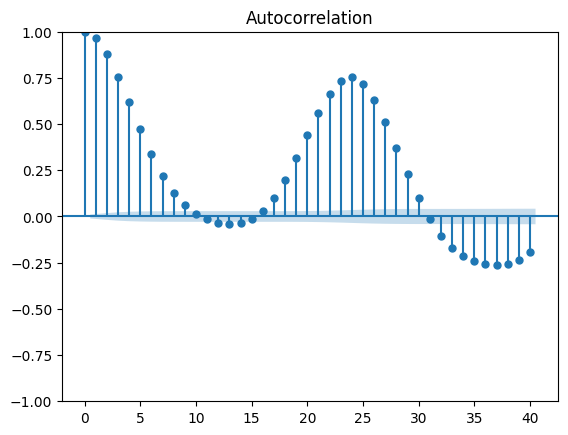

<Figure size 1000x600 with 0 Axes>

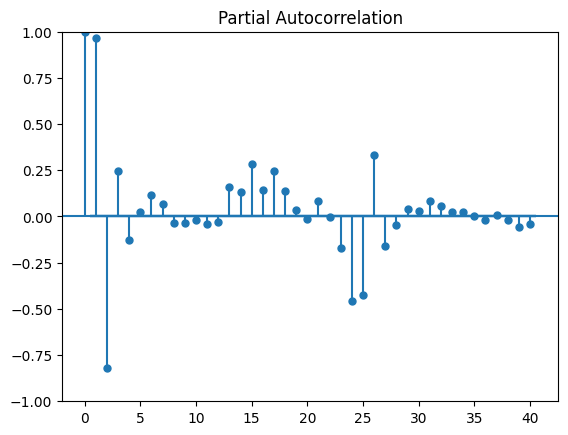

In [8]:
# Visualize ACF and PACF for the target variable
plt.figure(figsize=(10, 6))
plot_acf(y_transformed, lags=40)
plt.show()

plt.figure(figsize=(10, 6))
plot_pacf(y_transformed, lags=40)
plt.show()


In [27]:
# 3. Scaling (optional): Scale the exogenous variables if necessary
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Only scaling the exogenous variables

In [28]:
# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(df) * 0.8)
train_y, test_y = y_transformed[:train_size], y_transformed[train_size:]
train_X, test_X = X_scaled[:train_size], X_scaled[train_size:]

In [29]:
# # 4. Define the range of hyperparameters to optimize
# p = q = range(0, 2)  # AR and MA parameters
# d = range(0, 1)  # Fix differentiation at 1

# P = Q = range(0, 2)  # Seasonal AR and MA parameters
# D = range(0, 1)  # Fix seasonal differentiation at 1

# S = [24]  # Daily seasonality (24 hours)

In [30]:
# # Generate combinations of parameters
# param_grid = [
#     ((p1, d1, q1), (P1, D1, Q1, S1))
#     for p1 in p for d1 in d for q1 in q
#     for P1 in P for D1 in D for Q1 in Q for S1 in S
# ]

In [31]:
# # 5. Train the model with simple grid search and TimeSeriesSplit
# best_aic = np.inf
# best_params = None
# best_model = None


In [32]:
# def fit_sarimax(params):
#     try:
#         model = SARIMAX(train_y, exog=train_X, order=params[0], seasonal_order=params[1])
#         result = model.fit(disp=False)
#         return result.aic, params, result
#     except:
#         return np.inf, None, None
# # Parallel processing
# results = Parallel(n_jobs=4)(delayed(fit_sarimax)(param) for param in param_grid)
# # Select the best result
# best_result = min(results, key=lambda x: x[0])
# best_aic, best_params, best_model = best_result

/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
Python(52856) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(52857) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(52858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
/Users/alejandrovelazco/work/master-tfm/.venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date i

In [ ]:
# Use auto_arima from pmdarima to get initial best parameters
print("Running auto_arima for initial parameter search...")
auto_model = pm.auto_arima(train_y, exogenous_variables=train_X, seasonal=True, m=24, stepwise=True, trace=True)
best_order = auto_model.order
best_seasonal_order = auto_model.seasonal_order
print(f"Best order: {best_order}, Best seasonal order: {best_seasonal_order}")

In [15]:
# Show the best parameters
print(f"Best parameters: {best_params}")
print(f"Best model AIC: {best_aic}")

Best parameters: ((0, 0, 0), (1, 0, 0, 24))
Best model AIC: 14.0


In [18]:
# 6. Evaluate the model on the test set
predictions = best_model.predict(start=test_y.index[0], end=test_y.index[-1], exog=test_X)

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [ ]:
# Reverse Box-Cox transformation if applied
if 'lam' in locals():
    predictions = np.exp(np.log(predictions * lam + 1) / lam)  # Reverse transformation
    test_y = np.exp(np.log(test_y * lam + 1) / lam)

In [ ]:
# 7. Calculate metrics: RMSE, MAE, R2
rmse = np.sqrt(mean_squared_error(test_y, predictions))
mae = mean_absolute_error(test_y, predictions)
r2 = r2_score(test_y, predictions)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

# 8. Plot the results
plt.figure(figsize=(10, 6))
plt.plot(test_y, label='Actual')
plt.plot(predictions, label='Prediction', linestyle='--')
plt.title('Prediction vs Actual - SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.legend()
plt.grid(True)
plt.show()